# Neural Network Model for TANAP Boundaries Prediction

This notebook implements and evaluates a Neural Network model for predicting TANAP boundaries in historical document scans.

## Model Overview
- **Task**: Multi-class classification (NONE, START, MIDDLE, END)
- **Algorithm**: Multi-layer Perceptron (MLP) with TensorFlow/Keras
- **Features**: XML layout features + XMI NER features + sequence features
- **Advantages**: Can learn complex non-linear patterns, handles high-dimensional data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

Libraries imported successfully!
TensorFlow version: 2.19.0
GPU available: []


## Data Loading and Preprocessing

In [17]:
# Load the feature dataset
df = pd.read_csv('../data/train/features_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['TANAP Boundaries'].value_counts())
print(f"\nTarget percentages:")
print(df['TANAP Boundaries'].value_counts(normalize=True) * 100)

Dataset shape: (16774, 69)

Target distribution:
TANAP Boundaries
MIDDLE    13058
NONE       1535
START      1091
END        1090
Name: count, dtype: int64

Target percentages:
TANAP Boundaries
MIDDLE    77.846667
NONE       9.151067
START      6.504114
END        6.498152
Name: proportion, dtype: float64


In [18]:
# Prepare features and target
feature_cols = [col for col in df.columns if col not in ['Scan File_Name', 'TANAP Boundaries']]
X = df[feature_cols]
y = df['TANAP Boundaries']

print(f"Number of features: {len(feature_cols)}")

# Handle missing values
missing_data = X.isnull().sum()
if missing_data.sum() > 0:
    print(f"\nMissing values found:")
    print(missing_data[missing_data > 0])
    X = X.fillna(X.median())
else:
    print("\nNo missing values found.")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes = len(label_encoder.classes_)

print("\nLabel encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")
print(f"Number of classes: {n_classes}")

Number of features: 67

No missing values found.

Label encoding:
0: END
1: MIDDLE
2: NONE
3: START
Number of classes: 4


In [19]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Further split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

print(f"\nFeature scaling completed.")
print(f"Categorical labels shape: {y_train_cat.shape}")

# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"\nClass weights: {class_weight_dict}")

Training set shape: (10735, 67)
Validation set shape: (2684, 67)
Test set shape: (3355, 67)

Feature scaling completed.
Categorical labels shape: (10735, 4)

Class weights: {np.int64(0): np.float64(3.844914040114613), np.int64(1): np.float64(0.3211379681703961), np.int64(2): np.float64(2.7329429735234214), np.int64(3): np.float64(3.844914040114613)}


## Neural Network Architecture Design

In [20]:
def create_neural_network(input_dim, n_classes, architecture='medium'):
    """
    Create a neural network model with different architectures
    """
    model = keras.Sequential()
    
    if architecture == 'simple':
        # Simple architecture
        model.add(layers.Dense(64, activation='relu', input_shape=(input_dim,)))
        model.add(layers.Dropout(0.3))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.3))
        
    elif architecture == 'medium':
        # Medium architecture
        model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.3))
        
    elif architecture == 'deep':
        # Deep architecture
        model.add(layers.Dense(256, activation='relu', input_shape=(input_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.3))
    
    # Output layer
    model.add(layers.Dense(n_classes, activation='softmax'))
    
    return model

# Test different architectures
input_dim = X_train_scaled.shape[1]
architectures = ['simple', 'medium', 'deep']

print(f"Input dimension: {input_dim}")
print(f"Number of classes: {n_classes}")
print("\nTesting different architectures:")

for arch in architectures:
    model = create_neural_network(input_dim, n_classes, arch)
    total_params = model.count_params()
    print(f"{arch.capitalize()} architecture: {total_params:,} parameters")

Input dimension: 67
Number of classes: 4

Testing different architectures:
Simple architecture: 6,564 parameters
Medium architecture: 19,940 parameters
Deep architecture: 62,564 parameters


## Model Training and Hyperparameter Tuning

In [21]:
# Define hyperparameters to tune
hyperparameters = {
    'architectures': ['medium', 'deep'],  # Reduced for faster execution
    'learning_rates': [0.001, 0.01],
    'batch_sizes': [32, 64, 128],
    'optimizers': ['adam', 'rmsprop']
}

# Grid search for neural network
def neural_network_grid_search(X_train, y_train, X_val, y_val, hyperparameters, class_weights):
    """
    Perform grid search for neural network hyperparameters
    """
    best_score = 0
    best_params = {}
    best_model = None
    results = []
    
    total_combinations = (len(hyperparameters['architectures']) * 
                         len(hyperparameters['learning_rates']) * 
                         len(hyperparameters['batch_sizes']) * 
                         len(hyperparameters['optimizers']))
    
    print(f"Testing {total_combinations} hyperparameter combinations...")
    
    combination = 0
    for arch in hyperparameters['architectures']:
        for lr in hyperparameters['learning_rates']:
            for batch_size in hyperparameters['batch_sizes']:
                for optimizer in hyperparameters['optimizers']:
                    combination += 1
                    print(f"\nCombination {combination}/{total_combinations}: {arch}, lr={lr}, batch={batch_size}, opt={optimizer}")
                    
                    # Create model
                    model = create_neural_network(X_train.shape[1], n_classes, arch)
                    
                    # Compile model
                    model.compile(
                        optimizer=keras.optimizers.Adam(learning_rate=lr) if optimizer == 'adam' else keras.optimizers.RMSprop(learning_rate=lr),
                        loss='categorical_crossentropy',
                        metrics=['accuracy']
                    )
                    
                    # Train model
                    history = model.fit(
                        X_train, y_train,
                        batch_size=batch_size,
                        epochs=20,  # Reduced epochs for grid search
                        validation_data=(X_val, y_val),
                        class_weight=class_weights,
                        verbose=0
                    )
                    
                    # Get best validation accuracy
                    val_accuracy = max(history.history['val_accuracy'])
                    
                    # Store results
                    params = {
                        'architecture': arch,
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'optimizer': optimizer
                    }
                    results.append({**params, 'val_accuracy': val_accuracy})
                    
                    print(f"Validation accuracy: {val_accuracy:.4f}")
                    
                    # Update best model
                    if val_accuracy > best_score:
                        best_score = val_accuracy
                        best_params = params
                        best_model = model
    
    return best_model, best_params, best_score, results

# Perform grid search
best_model, best_params, best_score, search_results = neural_network_grid_search(
    X_train_scaled, y_train_cat, X_val_scaled, y_val_cat, hyperparameters, class_weight_dict
)

print(f"\nBest parameters: {best_params}")
print(f"Best validation score: {best_score:.4f}")

Testing 24 hyperparameter combinations...

Combination 1/24: medium, lr=0.001, batch=32, opt=adam
Validation accuracy: 0.7612

Combination 2/24: medium, lr=0.001, batch=32, opt=rmsprop
Validation accuracy: 0.7519

Combination 3/24: medium, lr=0.001, batch=64, opt=adam
Validation accuracy: 0.7724

Combination 4/24: medium, lr=0.001, batch=64, opt=rmsprop
Validation accuracy: 0.7481

Combination 5/24: medium, lr=0.001, batch=128, opt=adam
Validation accuracy: 0.7750

Combination 6/24: medium, lr=0.001, batch=128, opt=rmsprop
Validation accuracy: 0.7742

Combination 7/24: medium, lr=0.01, batch=32, opt=adam
Validation accuracy: 0.7806

Combination 8/24: medium, lr=0.01, batch=32, opt=rmsprop
Validation accuracy: 0.8014

Combination 9/24: medium, lr=0.01, batch=64, opt=adam
Validation accuracy: 0.7798

Combination 10/24: medium, lr=0.01, batch=64, opt=rmsprop
Validation accuracy: 0.8118

Combination 11/24: medium, lr=0.01, batch=128, opt=adam
Validation accuracy: 0.7858

Combination 12/24:

## Final Model Training

In [22]:
# Create and train the final model with best parameters
final_model = create_neural_network(input_dim, n_classes, best_params['architecture'])

# Compile with best parameters
optimizer = keras.optimizers.Adam(learning_rate=best_params['learning_rate']) if best_params['optimizer'] == 'adam' else keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])

final_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Final Model Architecture:")
final_model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('../models/best_neural_network.h5', monitor='val_accuracy', save_best_only=True)
]

# Train the final model
print("\nTraining final model...")
history = final_model.fit(
    X_train_scaled, y_train_cat,
    batch_size=best_params['batch_size'],
    epochs=100,
    validation_data=(X_val_scaled, y_val_cat),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Final Model Architecture:


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_220 (Dense)               │ (None, 256)            │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,564 (244.39 KB)

 Trainable params: 61,668 (240.89 KB)

 Non-trainable params: 896 (3.50 KB)


Training final model...
Epoch 1/100
62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4669 - loss: 1.2772 - precision: 0.5484 - recall: 0.3070   

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5689 - loss: 1.0505 - precision: 0.6893 - recall: 0.4273 - val_accuracy: 0.6870 - val_loss: 1.0150 - val_precision: 0.7733 - val_recall: 0.5745 - learning_rate: 0.0100
Epoch 2/100
59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6509 - loss: 0.9006 - precision: 0.7759 - recall: 0.5353

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6630 - loss: 0.8560 - precision: 0.7800 - recall: 0.5520 - val_accuracy: 0.7481 - val_loss: 0.8660 - val_precision: 0.7918 - val_recall: 0.7098 - learning_rate: 0.0100
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6981 - loss: 0.8231 - precision: 0.8002 - recall: 0.6041 - val_accuracy: 0.7362 - val_loss: 0.8226 - val_precision: 0.7903 - val_recall: 0.7034 - learning_rate: 0.0100
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6948 - loss: 0.8117 - precision: 0.7997 - recall: 0.6013 - val_accuracy: 0.7366 - val_loss: 0.7533 - val_precision: 0.8061 - val_recall: 0.6829 - learning_rate: 0.0100
Epoch 5/100
60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6928 - loss: 0.8293 - precision: 0.8041 - recall: 0.5956

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7002 - loss: 0.7928 - precision: 0.8012 - recall: 0.6119 - val_accuracy: 0.7806 - val_loss: 0.6402 - val_precision: 0.8324 - val_recall: 0.7310 - learning_rate: 0.0100
Epoch 6/100
58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7122 - loss: 0.8072 - precision: 0.8053 - recall: 0.6166

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7203 - loss: 0.7680 - precision: 0.8081 - recall: 0.6367 - val_accuracy: 0.7820 - val_loss: 0.6312 - val_precision: 0.8231 - val_recall: 0.7526 - learning_rate: 0.0100
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7079 - loss: 0.7417 - precision: 0.7978 - recall: 0.6312 - val_accuracy: 0.7649 - val_loss: 0.6518 - val_precision: 0.8423 - val_recall: 0.7027 - learning_rate: 0.0100
Epoch 8/100
58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7045 - loss: 0.7818 - precision: 0.8020 - recall: 0.6165

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7214 - loss: 0.7418 - precision: 0.8095 - recall: 0.6383 - val_accuracy: 0.7843 - val_loss: 0.6213 - val_precision: 0.8331 - val_recall: 0.7455 - learning_rate: 0.0100
Epoch 9/100
60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7144 - loss: 0.7567 - precision: 0.8090 - recall: 0.6433

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7167 - loss: 0.7306 - precision: 0.8071 - recall: 0.6447 - val_accuracy: 0.7928 - val_loss: 0.6127 - val_precision: 0.8351 - val_recall: 0.7586 - learning_rate: 0.0100
Epoch 10/100
59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7232 - loss: 0.7347 - precision: 0.8043 - recall: 0.6498

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7289 - loss: 0.7161 - precision: 0.8163 - recall: 0.6560 - val_accuracy: 0.8040 - val_loss: 0.5758 - val_precision: 0.8325 - val_recall: 0.7798 - learning_rate: 0.0100
Epoch 11/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7177 - loss: 0.7241 - precision: 0.8044 - recall: 0.6463 - val_accuracy: 0.7720 - val_loss: 0.6366 - val_precision: 0.8220 - val_recall: 0.7347 - learning_rate: 0.0100
Epoch 12/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7140 - loss: 0.7072 - precision: 0.8046 - recall: 0.6499 - val_accuracy: 0.7634 - val_loss: 0.6118 - val_precision: 0.8254 - val_recall: 0.7221 - learning_rate: 0.0100
Epoch 13/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.6980 - precision: 0.8074 - recall: 0.6650 - val_accuracy: 0.7861 - val_loss: 0.5740 - val_precision: 0.8507 - val_recall: 0.7452 - learning_rate: 0.0100
Epoch 14/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7267 - loss

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7323 - loss: 0.6870 - precision: 0.8036 - recall: 0.6623 - val_accuracy: 0.8081 - val_loss: 0.5658 - val_precision: 0.8392 - val_recall: 0.7720 - learning_rate: 0.0100
Epoch 17/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7385 - loss: 0.6807 - precision: 0.8113 - recall: 0.6707 - val_accuracy: 0.7861 - val_loss: 0.6086 - val_precision: 0.8310 - val_recall: 0.7403 - learning_rate: 0.0100
Epoch 18/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7410 - loss: 0.6830 - precision: 0.8064 - recall: 0.6766 - val_accuracy: 0.7984 - val_loss: 0.5735 - val_precision: 0.8317 - val_recall: 0.7675 - learning_rate: 0.0100
Epoch 19/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7462 - loss: 0.6425 - precision: 0.8125 - recall: 0.6929 - val_accuracy: 0.8059 - val_loss: 0.5449 - val_precision: 0.8488 - val_recall: 0.7612 - learning_rate: 0.0100
Epoch 20/100
80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7303 - loss

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7395 - loss: 0.6758 - precision: 0.8057 - recall: 0.6777 - val_accuracy: 0.8118 - val_loss: 0.5298 - val_precision: 0.8488 - val_recall: 0.7783 - learning_rate: 0.0100
Epoch 21/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7475 - loss: 0.6522 - precision: 0.8112 - recall: 0.6941 - val_accuracy: 0.7891 - val_loss: 0.5876 - val_precision: 0.8284 - val_recall: 0.7645 - learning_rate: 0.0100
Epoch 22/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7348 - loss: 0.6642 - precision: 0.8016 - recall: 0.6810 - val_accuracy: 0.7984 - val_loss: 0.5611 - val_precision: 0.8474 - val_recall: 0.7675 - learning_rate: 0.0100
Epoch 23/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7423 - loss: 0.6489 - precision: 0.8071 - recall: 0.6853 - val_accuracy: 0.8048 - val_loss: 0.5299 - val_precision: 0.8438 - val_recall: 0.7828 - learning_rate: 0.0100
Epoch 24/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7388 - loss

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7574 - loss: 0.6015 - precision: 0.8110 - recall: 0.7090 - val_accuracy: 0.8148 - val_loss: 0.5087 - val_precision: 0.8468 - val_recall: 0.7910 - learning_rate: 0.0050
Epoch 28/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 0.5794 - precision: 0.8162 - recall: 0.7185 - val_accuracy: 0.7835 - val_loss: 0.5915 - val_precision: 0.8251 - val_recall: 0.7575 - learning_rate: 0.0050
Epoch 29/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7568 - loss: 0.6078 - precision: 0.8100 - recall: 0.7075 - val_accuracy: 0.8085 - val_loss: 0.5345 - val_precision: 0.8463 - val_recall: 0.7798 - learning_rate: 0.0050
Epoch 30/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7590 - loss: 0.5921 - precision: 0.8193 - recall: 0.7144 - val_accuracy: 0.7999 - val_loss: 0.5483 - val_precision: 0.8342 - val_recall: 0.7724 - learning_rate: 0.0050
Epoch 31/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7603 - loss

## Model Evaluation

In [23]:
# Make predictions
y_train_pred_proba = final_model.predict(X_train_scaled, verbose=0)
y_val_pred_proba = final_model.predict(X_val_scaled, verbose=0)
y_test_pred_proba = final_model.predict(X_test_scaled, verbose=0)

# Convert probabilities to class predictions
y_train_pred = np.argmax(y_train_pred_proba, axis=1)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate F1 scores
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nTraining F1-score: {train_f1:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Training Accuracy: 0.8251
Validation Accuracy: 0.8148
Test Accuracy: 0.8122

Training F1-score: 0.8442
Validation F1-score: 0.8344
Test F1-score: 0.8318


In [24]:
# Detailed classification report
class_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(
    y_test, y_test_pred, 
    target_names=class_names,
    digits=4
))

Classification Report:
              precision    recall  f1-score   support

         END     0.3416    0.6284    0.4426       218
      MIDDLE     0.9678    0.8277    0.8923      2612
        NONE     0.7162    0.8795    0.7895       307
       START     0.4548    0.7156    0.5561       218

    accuracy                         0.8122      3355
   macro avg     0.6201    0.7628    0.6701      3355
weighted avg     0.8707    0.8122    0.8318      3355



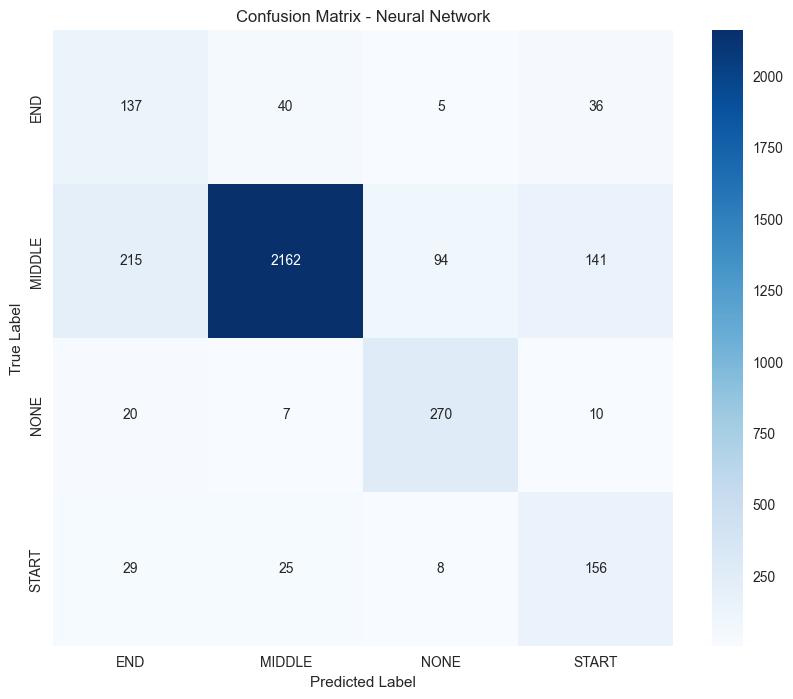


Per-class Metrics:
    Class  Precision  Recall  F1-Score  Support
0     END     0.3416  0.6284    0.4426      218
1  MIDDLE     0.9678  0.8277    0.8923     2612
2    NONE     0.7162  0.8795    0.7895      307
3   START     0.4548  0.7156    0.5561      218


In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, average=None
)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-class Metrics:")
print(metrics_df.round(4))

## Training History Analysis

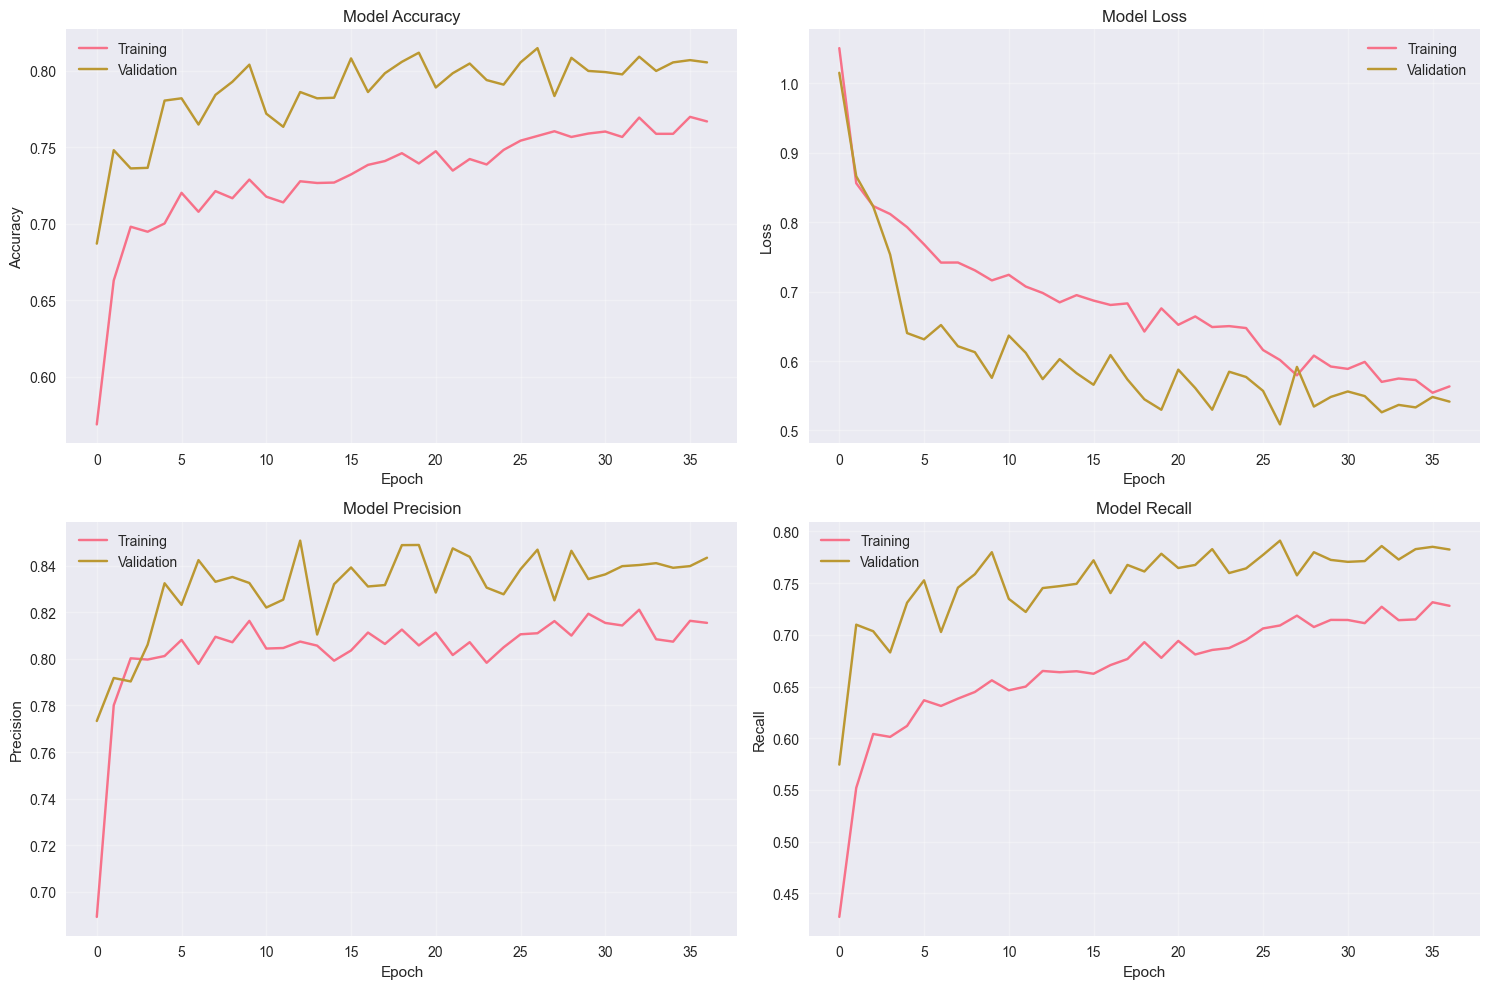


Training Statistics:
Total epochs trained: 37
Best epoch: 27
Best validation accuracy: 0.8148
Final training accuracy: 0.7669
Final validation accuracy: 0.8055


In [26]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training')
axes[0, 1].plot(history.history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
if 'precision' in history.history:
    axes[1, 0].plot(history.history['precision'], label='Training')
    axes[1, 0].plot(history.history['val_precision'], label='Validation')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Recall
if 'recall' in history.history:
    axes[1, 1].plot(history.history['recall'], label='Training')
    axes[1, 1].plot(history.history['val_recall'], label='Validation')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training statistics
total_epochs = len(history.history['loss'])
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = max(history.history['val_accuracy'])

print(f"\nTraining Statistics:")
print(f"Total epochs trained: {total_epochs}")
print(f"Best epoch: {best_epoch}")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

## Prediction Confidence Analysis

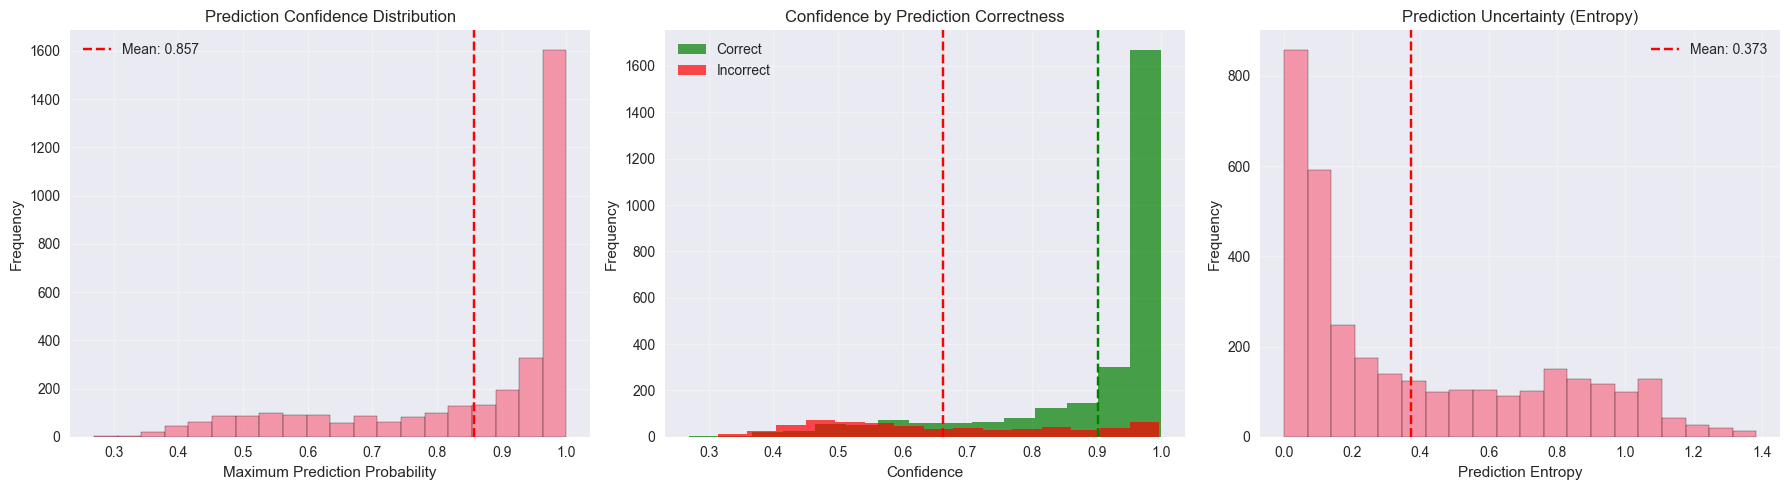


Prediction Confidence Analysis:
Average confidence: 0.8570
Confidence for correct predictions: 0.9020
Confidence for incorrect predictions: 0.6621
Average prediction entropy: 0.3734
Standard deviation of entropy: 0.3675


In [27]:
# Analyze prediction confidence
max_probs = np.max(y_test_pred_proba, axis=1)
predicted_entropy = -np.sum(y_test_pred_proba * np.log(y_test_pred_proba + 1e-8), axis=1)

# Create confidence analysis dataframe
confidence_df = pd.DataFrame({
    'True_Class': [class_names[i] for i in y_test],
    'Predicted_Class': [class_names[i] for i in y_test_pred],
    'Confidence': max_probs,
    'Entropy': predicted_entropy,
    'Correct': y_test == y_test_pred
})

# Plot confidence distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Overall confidence distribution
axes[0].hist(max_probs, bins=20, alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(max_probs), color='red', linestyle='--', 
               label=f'Mean: {np.mean(max_probs):.3f}')
axes[0].set_xlabel('Maximum Prediction Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confidence by correctness
correct_conf = confidence_df[confidence_df['Correct']]['Confidence']
incorrect_conf = confidence_df[~confidence_df['Correct']]['Confidence']

axes[1].hist(correct_conf, bins=15, alpha=0.7, label='Correct', color='green')
axes[1].hist(incorrect_conf, bins=15, alpha=0.7, label='Incorrect', color='red')
axes[1].axvline(np.mean(correct_conf), color='green', linestyle='--')
axes[1].axvline(np.mean(incorrect_conf), color='red', linestyle='--')
axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Confidence by Prediction Correctness')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Entropy distribution
axes[2].hist(predicted_entropy, bins=20, alpha=0.7, edgecolor='black')
axes[2].axvline(np.mean(predicted_entropy), color='red', linestyle='--', 
               label=f'Mean: {np.mean(predicted_entropy):.3f}')
axes[2].set_xlabel('Prediction Entropy')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Prediction Uncertainty (Entropy)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPrediction Confidence Analysis:")
print(f"Average confidence: {np.mean(max_probs):.4f}")
print(f"Confidence for correct predictions: {np.mean(correct_conf):.4f}")
print(f"Confidence for incorrect predictions: {np.mean(incorrect_conf):.4f}")
print(f"Average prediction entropy: {np.mean(predicted_entropy):.4f}")
print(f"Standard deviation of entropy: {np.std(predicted_entropy):.4f}")

## Hyperparameter Search Results Analysis

Top 10 Hyperparameter Combinations:
   architecture  learning_rate  batch_size optimizer  val_accuracy
23         deep          0.010         128   rmsprop      0.818554
9        medium          0.010          64   rmsprop      0.811848
7        medium          0.010          32   rmsprop      0.801416
11       medium          0.010         128   rmsprop      0.798063
19         deep          0.010          32   rmsprop      0.797690
21         deep          0.010          64   rmsprop      0.791356
10       medium          0.010         128      adam      0.785767
17         deep          0.001         128   rmsprop      0.785395
15         deep          0.001          64   rmsprop      0.783532
6        medium          0.010          32      adam      0.780551


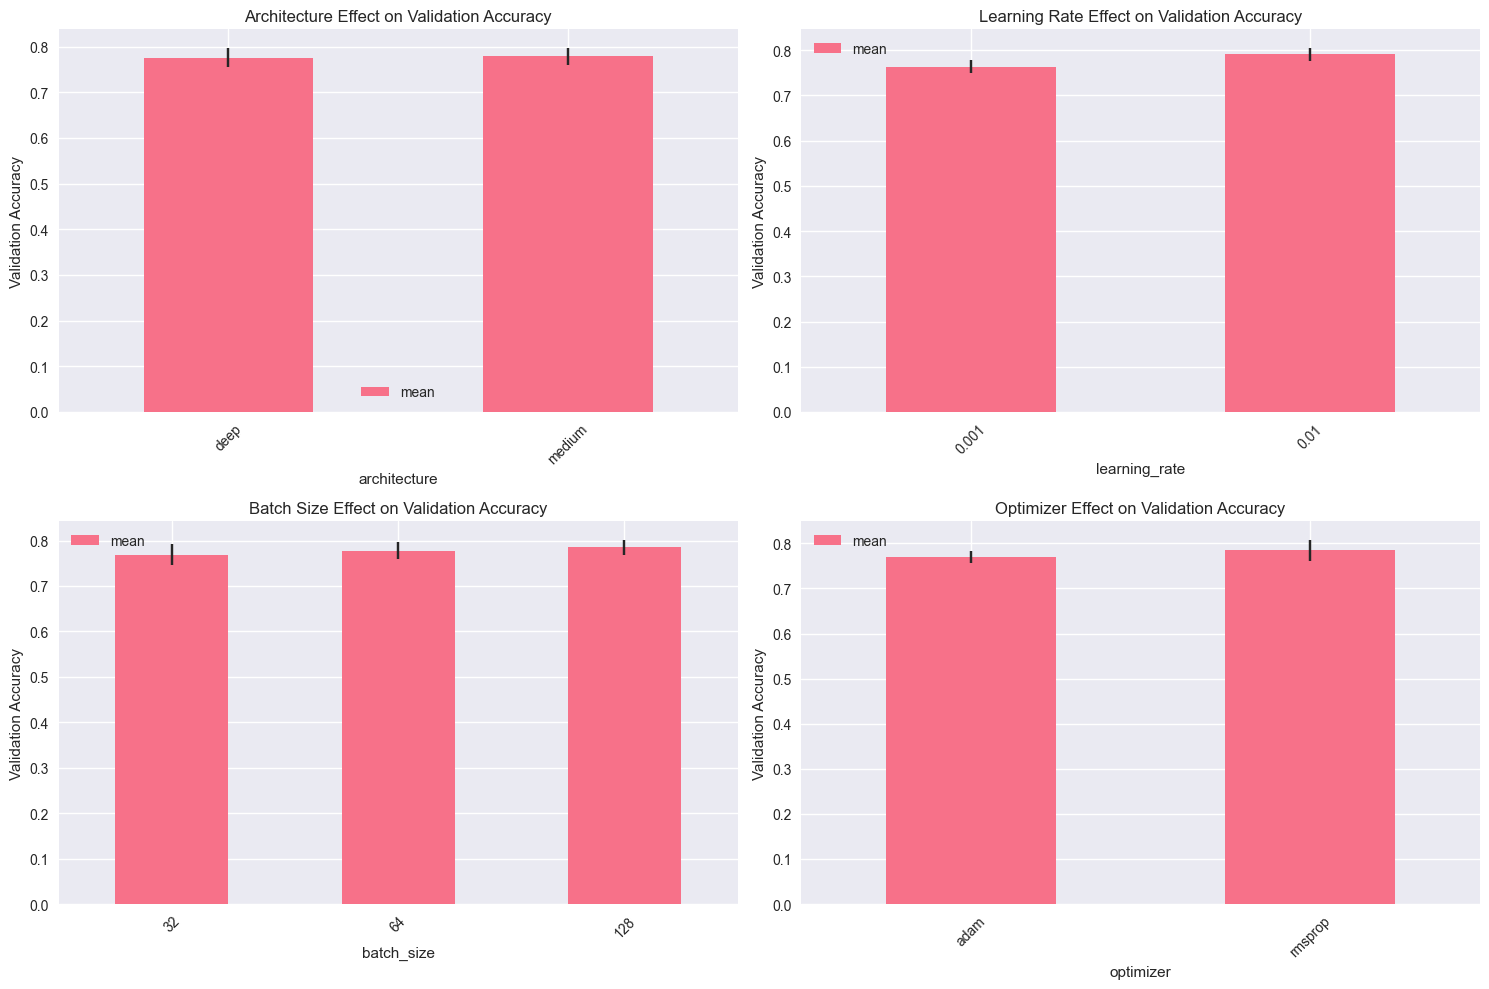


Hyperparameter Effect Summary:
Best Architecture: medium (avg: 0.7783)
Best Learning Rate: 0.01 (avg: 0.7907)
Best Batch Size: 128 (avg: 0.7849)
Best Optimizer: rmsprop (avg: 0.7846)


In [28]:
# Analyze hyperparameter search results
search_df = pd.DataFrame(search_results)
search_df = search_df.sort_values('val_accuracy', ascending=False)

print("Top 10 Hyperparameter Combinations:")
print(search_df.head(10))

# Visualize hyperparameter effects
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Architecture effect
arch_effect = search_df.groupby('architecture')['val_accuracy'].agg(['mean', 'std'])
arch_effect.plot(kind='bar', y='mean', yerr='std', ax=axes[0, 0], capsize=4)
axes[0, 0].set_title('Architecture Effect on Validation Accuracy')
axes[0, 0].set_ylabel('Validation Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# Learning rate effect
lr_effect = search_df.groupby('learning_rate')['val_accuracy'].agg(['mean', 'std'])
lr_effect.plot(kind='bar', y='mean', yerr='std', ax=axes[0, 1], capsize=4)
axes[0, 1].set_title('Learning Rate Effect on Validation Accuracy')
axes[0, 1].set_ylabel('Validation Accuracy')
axes[0, 1].tick_params(axis='x', rotation=45)

# Batch size effect
batch_effect = search_df.groupby('batch_size')['val_accuracy'].agg(['mean', 'std'])
batch_effect.plot(kind='bar', y='mean', yerr='std', ax=axes[1, 0], capsize=4)
axes[1, 0].set_title('Batch Size Effect on Validation Accuracy')
axes[1, 0].set_ylabel('Validation Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)

# Optimizer effect
opt_effect = search_df.groupby('optimizer')['val_accuracy'].agg(['mean', 'std'])
opt_effect.plot(kind='bar', y='mean', yerr='std', ax=axes[1, 1], capsize=4)
axes[1, 1].set_title('Optimizer Effect on Validation Accuracy')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nHyperparameter Effect Summary:")
print(f"Best Architecture: {arch_effect.idxmax()['mean']} (avg: {arch_effect.max()['mean']:.4f})")
print(f"Best Learning Rate: {lr_effect.idxmax()['mean']} (avg: {lr_effect.max()['mean']:.4f})")
print(f"Best Batch Size: {batch_effect.idxmax()['mean']} (avg: {batch_effect.max()['mean']:.4f})")
print(f"Best Optimizer: {opt_effect.idxmax()['mean']} (avg: {opt_effect.max()['mean']:.4f})")

## Results Summary and Analysis

In [29]:
# Create comprehensive results summary
results_summary = {
    'Model': 'Neural Network (MLP)',
    'Best Parameters': best_params,
    'Architecture': best_params['architecture'],
    'Total Parameters': final_model.count_params(),
    'Training Accuracy': train_accuracy,
    'Validation Accuracy': val_accuracy,
    'Test Accuracy': test_accuracy,
    'Training F1-Score': train_f1,
    'Validation F1-Score': val_f1,
    'Test F1-Score': test_f1,
    'Number of Features': len(feature_cols),
    'Training Samples': len(X_train),
    'Validation Samples': len(X_val),
    'Test Samples': len(X_test),
    'Total Epochs': total_epochs,
    'Best Epoch': best_epoch,
    'Average Prediction Confidence': np.mean(max_probs),
    'Confidence Correct Predictions': np.mean(correct_conf),
    'Confidence Incorrect Predictions': np.mean(incorrect_conf),
    'Average Prediction Entropy': np.mean(predicted_entropy)
}

print("NEURAL NETWORK MODEL - FINAL RESULTS")
print("=" * 50)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    elif isinstance(value, int) and key == 'Total Parameters':
        print(f"{key}: {value:,}")
    else:
        print(f"{key}: {value}")

# Analysis and insights
print("\n" + "=" * 50)
print("ANALYSIS AND INSIGHTS")
print("=" * 50)

# Check for overfitting
if train_accuracy - test_accuracy > 0.05:
    print("⚠️  Potential overfitting detected (training accuracy >> test accuracy)")
else:
    print("✅ Good generalization (no significant overfitting)")

# Model performance assessment
if test_accuracy > 0.8:
    print("✅ High model performance (accuracy > 80%)")
elif test_accuracy > 0.7:
    print("⚡ Moderate model performance (accuracy 70-80%)")
else:
    print("⚠️  Low model performance (accuracy < 70%)")

# Training efficiency
if best_epoch < total_epochs * 0.5:
    print("✅ Efficient training (early convergence)")
else:
    print("⚡ Model required extended training")

# Prediction confidence assessment
avg_confidence = results_summary['Average Prediction Confidence']
if avg_confidence > 0.8:
    print("✅ High prediction confidence")
elif avg_confidence > 0.6:
    print("⚡ Moderate prediction confidence")
else:
    print("⚠️  Low prediction confidence")

# Confidence calibration
conf_diff = results_summary['Confidence Correct Predictions'] - results_summary['Confidence Incorrect Predictions']
if conf_diff > 0.1:
    print("✅ Well-calibrated confidence (higher confidence for correct predictions)")
else:
    print("⚠️  Poor confidence calibration")

print(f"\n🧠 Neural Network specific insights:")
print(f"   • Architecture: {best_params['architecture']} with {final_model.count_params():,} parameters")
print(f"   • Optimal learning rate: {best_params['learning_rate']}")
print(f"   • Optimal batch size: {best_params['batch_size']}")
print(f"   • Best optimizer: {best_params['optimizer']}")
print(f"   • Converged at epoch {best_epoch}/{total_epochs}")
print(f"   • Average prediction entropy: {np.mean(predicted_entropy):.4f} (lower = more confident)")

NEURAL NETWORK MODEL - FINAL RESULTS
Model: Neural Network (MLP)
Best Parameters: {'architecture': 'deep', 'learning_rate': 0.01, 'batch_size': 128, 'optimizer': 'rmsprop'}
Architecture: deep
Total Parameters: 62,564
Training Accuracy: 0.8251
Validation Accuracy: 0.8148
Test Accuracy: 0.8122
Training F1-Score: 0.8442
Validation F1-Score: 0.8344
Test F1-Score: 0.8318
Number of Features: 67
Training Samples: 10735
Validation Samples: 2684
Test Samples: 3355
Total Epochs: 37
Best Epoch: 27
Average Prediction Confidence: 0.8569552898406982
Confidence Correct Predictions: 0.9019989967346191
Confidence Incorrect Predictions: 0.6621235013008118
Average Prediction Entropy: 0.37337028980255127

ANALYSIS AND INSIGHTS
✅ Good generalization (no significant overfitting)
✅ High model performance (accuracy > 80%)
⚡ Model required extended training
✅ High prediction confidence
✅ Well-calibrated confidence (higher confidence for correct predictions)

🧠 Neural Network specific insights:
   • Architectur

## Save Model and Results

In [30]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the Keras model
final_model.save('../models/neural_network_model.h5')

# Save the scaler
joblib.dump(scaler, '../models/neural_network_scaler.pkl')

# Save results summary
results_df = pd.DataFrame([results_summary])
results_df.to_csv('../models/neural_network_results.csv', index=False)

# Save hyperparameter search results
search_df.to_csv('../models/neural_network_hyperparameter_search.csv', index=False)

# Save confidence analysis
confidence_df.to_csv('../models/neural_network_confidence_analysis.csv', index=False)

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('../models/neural_network_training_history.csv', index=False)

print("Model and results saved successfully!")
print("Saved files:")
print("  - ../models/neural_network_model.h5")
print("  - ../models/best_neural_network.h5 (best checkpoint)")
print("  - ../models/neural_network_scaler.pkl")
print("  - ../models/neural_network_results.csv")
print("  - ../models/neural_network_hyperparameter_search.csv")
print("  - ../models/neural_network_confidence_analysis.csv")
print("  - ../models/neural_network_training_history.csv")

Model and results saved successfully!
Saved files:
  - ../models/neural_network_model.h5
  - ../models/best_neural_network.h5 (best checkpoint)
  - ../models/neural_network_scaler.pkl
  - ../models/neural_network_results.csv
  - ../models/neural_network_hyperparameter_search.csv
  - ../models/neural_network_confidence_analysis.csv
  - ../models/neural_network_training_history.csv
